In [1]:
#https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 150)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os,random, math, psutil, pickle    

In [2]:
%%time
# 파일 읽어오기
train_df = pd.read_csv('train.csv')
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], format = '%Y-%m-%d %H:%M:%S')
weather_train_df = pd.read_csv('weather_train.csv')


test_df = pd.read_csv('test.csv')
weather_test_df = pd.read_csv('weather_test.csv')
building_meta_df = pd.read_csv('building_metadata.csv')
sample_submission = pd.read_csv('sample_submission.csv')

Wall time: 34.3 s


In [5]:
building_meta_df.columns

Index(['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count'],
      dtype='object')

In [11]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [13]:
# Glimpse of Data
print(train_df.shape)
print(weather_train_df.shape)
print(weather_test_df.shape)
print(building_meta_df.shape)

(20216100, 4)
(139773, 9)
(277243, 9)
(1449, 6)


## Reduce memory size

In [3]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
# Reducing memory
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


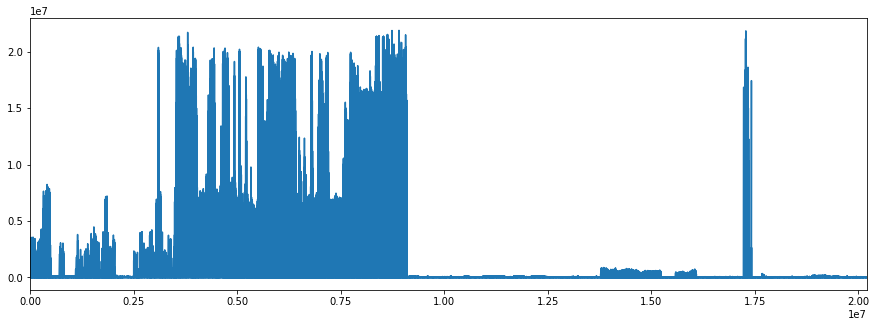

In [27]:
# Target Value 확인 - Meter_reading
plt.figure(figsize=(15,5))
train_df['meter_reading'].plot()

In [41]:
# train = train_df.set_index(['timestamp'])

# df = train[train.meter==1].copy().reset_index()
# df['timestamp2'] = pd.to_timedelta(df.timestamp).dt.total_seconds()/3600
# df
# df.timestamp-df.timestamp2.min()
# missmap = np.empty((1440,df.timestamp2.max()+1))
# missmap.fill(np.nan)

TypeError: 'numpy.float64' object cannot be interpreted as an integer

C:\Users\yseon\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning:

Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version



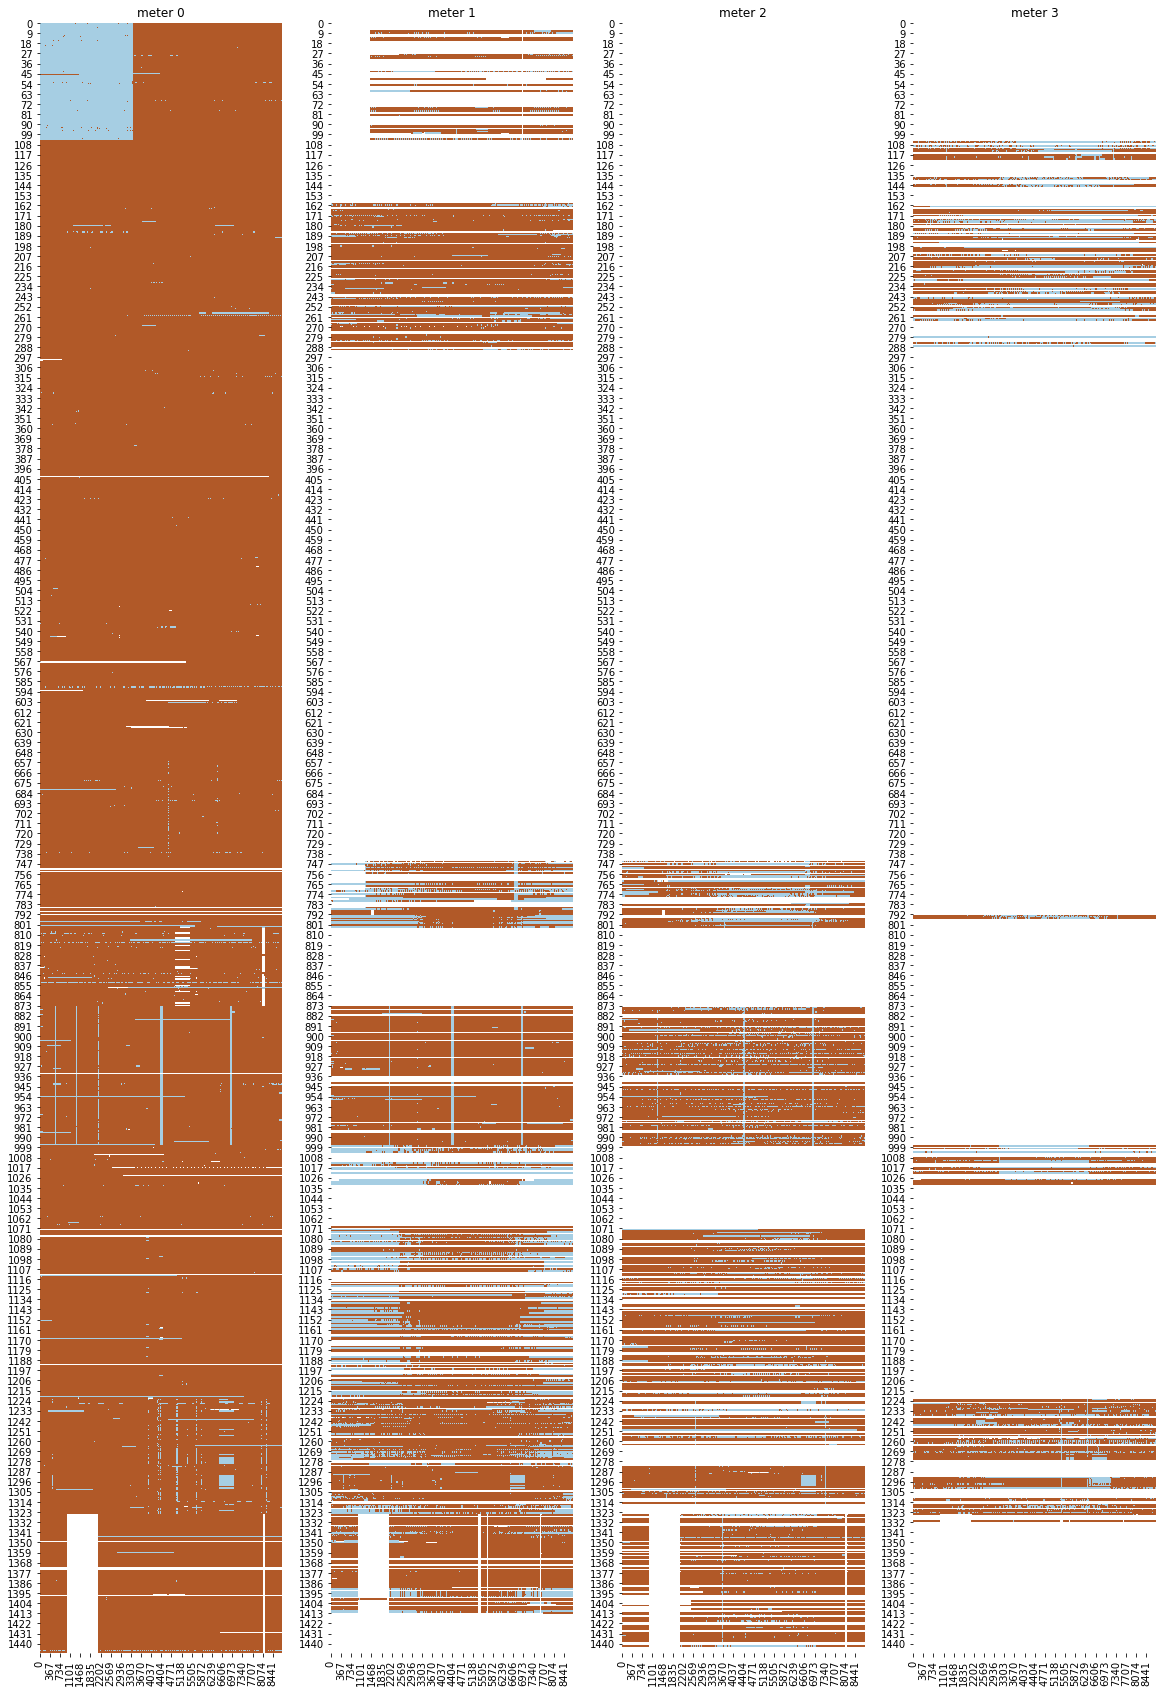

In [44]:
# Load data
train = train_df.set_index(['timestamp'])

# Plot missing values per building/meter
f,a=plt.subplots(1,4,figsize=(20,30))
for meter in np.arange(4):
    df = train[train.meter==meter].copy().reset_index()
    df['timestamp'] = pd.to_timedelta(df.timestamp).dt.total_seconds() / 3600
    df['timestamp'] = df.timestamp.astype(int)
    df.timestamp -= df.timestamp.min() # 최초시작점부터 걸린 시간
    missmap = np.empty((1449, df.timestamp.max()+1)) 
    missmap.fill(np.nan)
    for l in df.values:
        if l[2]!=meter:continue # l[1]
        missmap[int(l[1]), int(l[0])] = 0 if l[3]==0 else 1
    a[meter].set_title(f'meter {meter:d}')
    sns.heatmap(missmap, cmap='Paired', ax=a[meter], cbar=False)

Vertical blue lines may be suspicious
Legend:

X axis: hours elapsed since Jan 1st 2016, for each of the 4 meter types
Y axis: building_id
Brown: meter reading available with non-zero value
Light blue: meter reading available with zero value
White: missing meter reading

## Examine Missing Values.


In [58]:
#Checking missing data for train_df / weather_train_df

total = train_df.isnull().sum().sort_values(ascending =False)
total

meter_reading    0
timestamp        0
meter            0
building_id      0
dtype: int64

In [65]:
total = weather_train_df.isnull().sum().sort_values(ascending =False)
percent = (weather_train_df.isnull().sum()/weather_train_df.isnull().count()*100\
           ).sort_values(ascending=False)
missing_weather_data = pd.concat([total,percent],axis = 1, keys = ['Total','Percent'])
missing_weather_data.head()

,Total,Percent
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496


In [66]:
# Weather Test_df 

total = weather_test_df.isnull().sum().sort_values(ascending = False)
percent = (weather_test_df.isnull().sum()/weather_test_df.isnull().count()*100).sort_values(ascending = False)
missing_weather_test_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_weather_test_data.head(9)

,Total,Percent
cloud_coverage,140448,50.658808
precip_depth_1_hr,95588,34.478057
sea_level_pressure,21265,7.670167
wind_direction,12370,4.461790
wind_speed,460,0.165919
dew_temperature,327,0.117947
air_temperature,104,0.037512
timestamp,0,0.000000
site_id,0,0.000000


In [67]:
# Buliding_meta_df

# checking missing data
total = building_meta_df.isnull().sum().sort_values(ascending = False)
percent = (building_meta_df.isnull().sum()/building_meta_df.isnull().count()*100).sort_values(ascending = False)
missing_building_meta_df  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_building_meta_df.head(6)

,Total,Percent
floor_count,1094,75.500345
year_built,774,53.416149
square_feet,0,0.000000
primary_use,0,0.000000
building_id,0,0.000000
site_id,0,0.000000


## Columns


In [70]:
def plot_dist_col(column):
    '''plot dist curves for train and test weather data for the given column name'''
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.distplot(weather_train_df[column].dropna(), color='green', ax=ax).set_title(column, fontsize=16)
    sns.distplot(weather_test_df[column].dropna(), color='purple', ax=ax).set_title(column, fontsize=16)
    plt.xlabel(column, fontsize=15)
    plt.legend(['train', 'test'])
    plt.show()

In [71]:
weather_train_df.columns

Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')

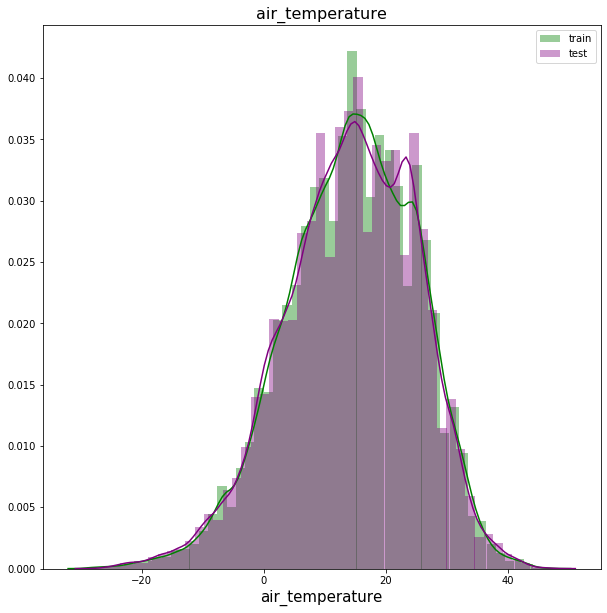

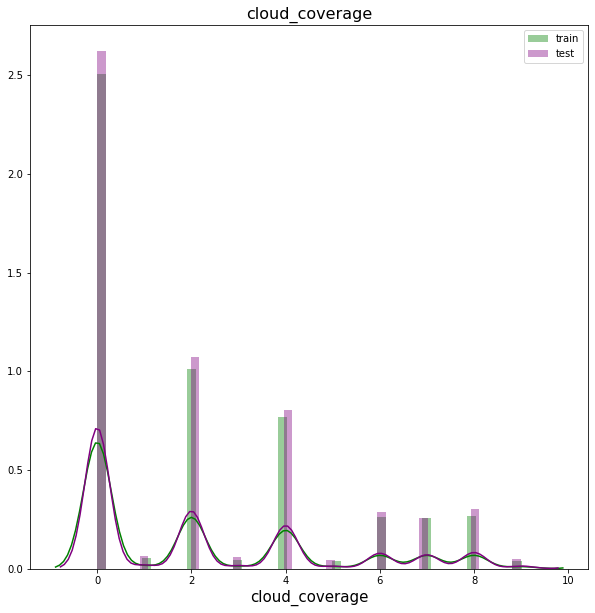

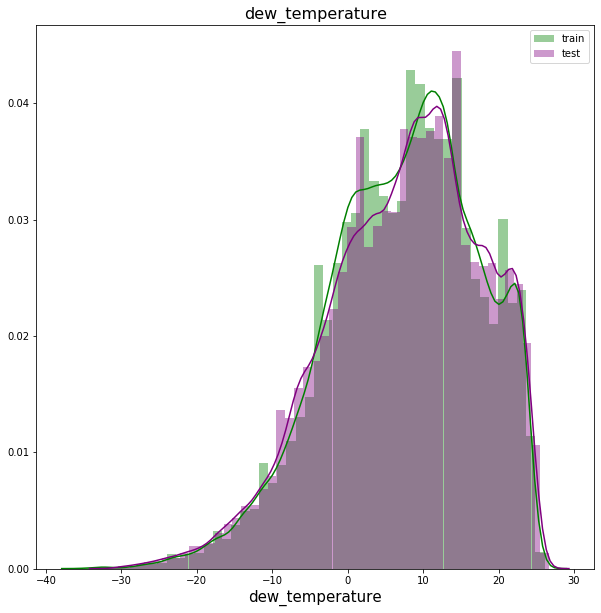

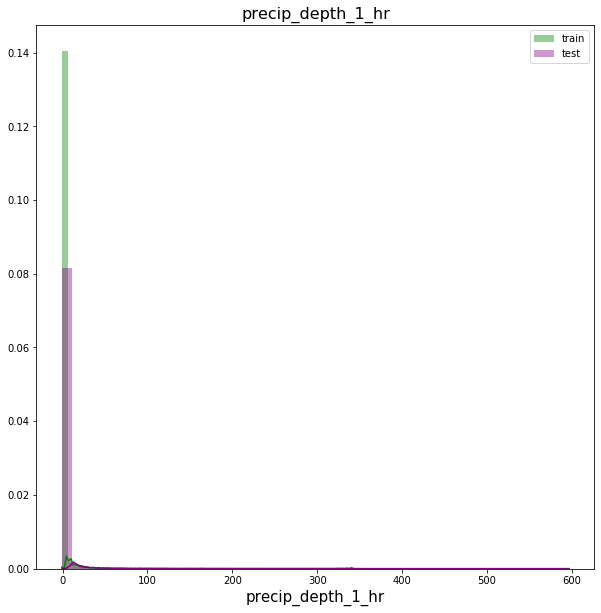

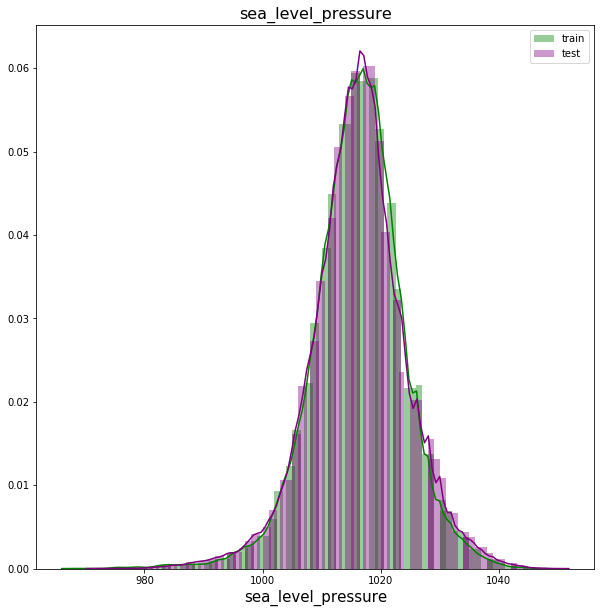

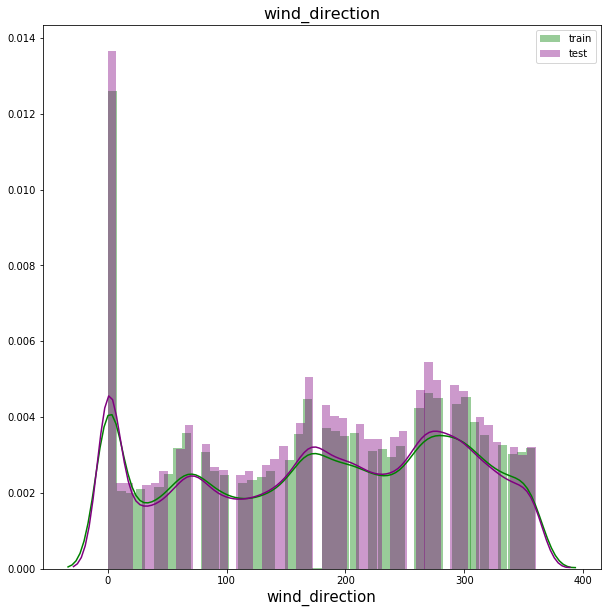

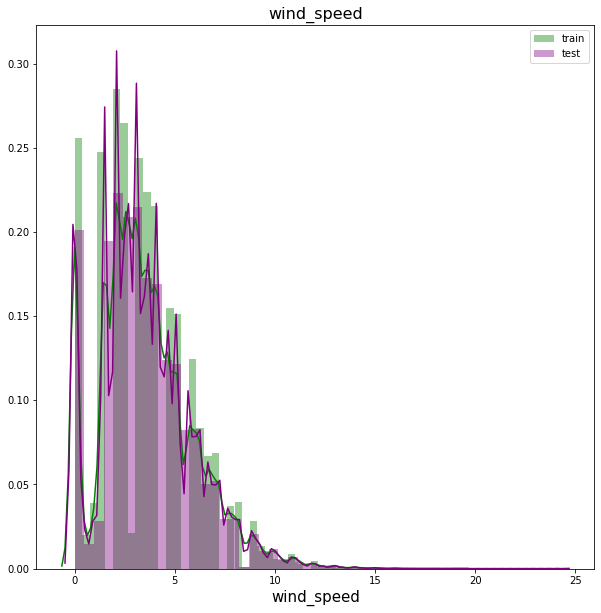

In [72]:
for col in weather_train_df.columns[2:]:
    plot_dist_col(col)
# air_temperature : train/test간 분포 차이 없다.
# cloud_coverage : 분포차이 없다.
# dew_temperature : train 대비 test가 약간 우측으로 쏠렸으나 크게 이상있진 않다.
# precip_depth_1_hr / sea_level_pressure / wind_direction
# wind_speed , 분포 차이는 보이지 않았다.

# Simple Single Series Analysis


In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose

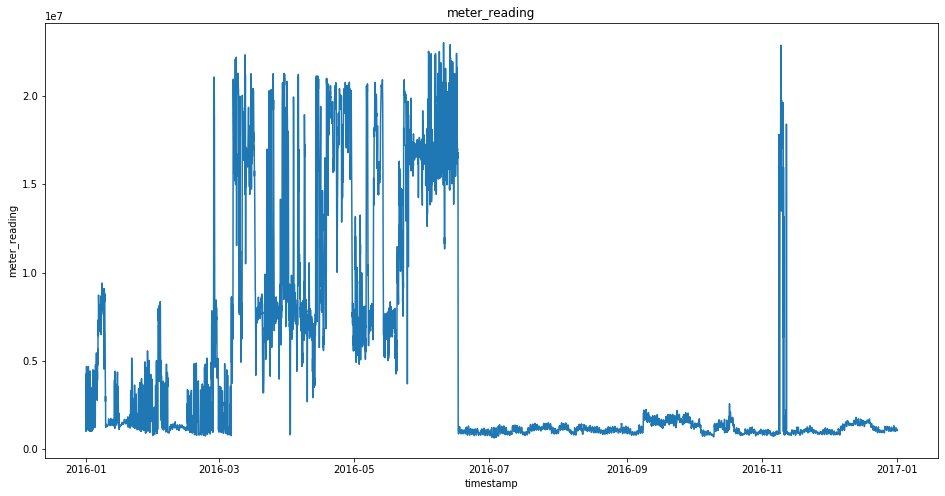

In [75]:
ts = train_df.groupby(["timestamp"])['meter_reading'].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('meter_reading')
plt.xlabel('timestamp')
plt.ylabel('meter_reading')
plt.plot(ts)

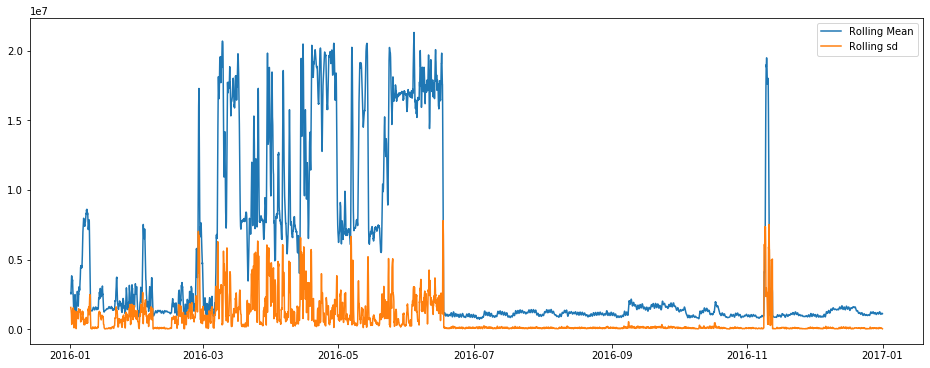

In [76]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

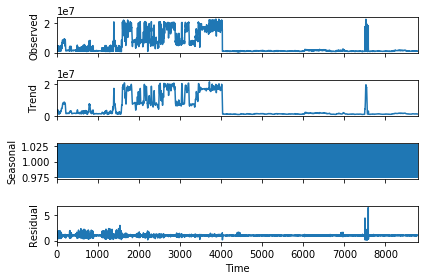

In [78]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()

In [112]:
train_df['meter'] = pd.Categorical(train_df['meter']).rename_categories({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})
daily_train = train_df.copy()
daily_train['date'] = daily_train['timestamp'].dt.date
daily_train = daily_train.groupby(['date', 'building_id', 'meter']).sum()
# daily_train.reset_index()

### Meter0 : electricity로 Baseline 모델을 잡고 Meter 1,2,3으로 업그레이드 해가는 방식으로
### 전략을 짜야하겠다.

In [95]:
# daily_train =daily_train.reset_index()
# 빌딩마다 체크하는게 4개가 있고 그 값들은 그때그때 다르다. 

# Meter0 : electricity로 Baseline 모델을 잡고 Meter 1,2,3으로 업그레이드 해가는 방식으로
# 전략을 짜야하겠다.
# daily_train[daily_train['building_id']==780]
# daily_train

### building id 별로 aggregation을 해야 하겠다


In [113]:
# Aggregate the data for buildings


daily_train_agg = daily_train.groupby(['date', 'meter']).agg(['sum', 'mean', 'idxmax', 'max'])
daily_train_agg = daily_train_agg.reset_index()
level_0 = daily_train_agg.columns.droplevel(0)
level_1 = daily_train_agg.columns.droplevel(1)
level_0 = ['' if x == '' else '-' + x for x in level_0]
daily_train_agg.columns = level_1 + level_0
daily_train_agg.rename_axis(None, axis=1)
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max
0,2016-01-01,chilledwater,1.412169e+06,3090.084961,"(2016-01-01, 1289, chilledwater)",1.042116e+05
1,2016-01-01,electricity,4.219648e+06,3037.903076,"(2016-01-01, 803, electricity)",1.160372e+05
2,2016-01-01,hotwater,1.609989e+06,11180.481445,"(2016-01-01, 1331, hotwater)",2.198245e+05
3,2016-01-01,steam,6.873201e+07,218891.734375,"(2016-01-01, 1099, steam)",5.095080e+07
4,2016-01-02,chilledwater,1.439740e+06,3157.324219,"(2016-01-02, 1289, chilledwater)",9.818726e+04


In [114]:
daily_train_agg['building_id_max'] = [x[1] for x in daily_train_agg['meter_reading-idxmax']]
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max,building_id_max
0,2016-01-01,chilledwater,1.412169e+06,3090.084961,"(2016-01-01, 1289, chilledwater)",1.042116e+05,1289
1,2016-01-01,electricity,4.219648e+06,3037.903076,"(2016-01-01, 803, electricity)",1.160372e+05,803
2,2016-01-01,hotwater,1.609989e+06,11180.481445,"(2016-01-01, 1331, hotwater)",2.198245e+05,1331
3,2016-01-01,steam,6.873201e+07,218891.734375,"(2016-01-01, 1099, steam)",5.095080e+07,1099
4,2016-01-02,chilledwater,1.439740e+06,3157.324219,"(2016-01-02, 1289, chilledwater)",9.818726e+04,1289


In [115]:
print('Number of days that a building has the maximum electricity consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'electricity']['building_id_max'].value_counts())

Number of days that a building has the maximum electricity consumption of all the buildings:

803     384
801     130
799     116
1088     98
993       2
794       2
Name: building_id_max, dtype: int64


In [116]:
daily_train_electricity = daily_train_agg[daily_train_agg['meter']=='electricity'].copy()
daily_train_electricity['building_id_max'] = pd.Categorical(daily_train_electricity['building_id_max'])
fig_daily_electricity = px.scatter(daily_train_electricity,
                                   x='date',
                                   y='meter_reading-max',
                                   color='building_id_max',
                                   render_mode='svg')
fig_daily_electricity.update_layout(title='Maximum consumption values for the day and energy aspect')
fig_daily_electricity.show()

In [118]:
# chilledwater

print('Number of days that a building has the maximum chilledwater consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'chilledwater']['building_id_max'].value_counts())

Number of days that a building has the maximum chilledwater consumption of all the buildings:

1284    268
76      184
1258     82
1289     76
778      74
1088     20
29       20
1156      4
60        2
50        2
Name: building_id_max, dtype: int64


In [119]:
daily_train_chilledwater = daily_train_agg[daily_train_agg['meter']=='chilledwater'].copy()
daily_train_chilledwater['building_id_max'] = pd.Categorical(daily_train_chilledwater['building_id_max'])
fig_daily_chilledwater = px.scatter(daily_train_chilledwater,
                                    x='date',
                                    y='meter_reading-max',  
                                    color='building_id_max', 
                                    render_mode='svg')
fig_daily_chilledwater.update_layout(title='Maximum consumption values for the day and energy aspect')
fig_daily_chilledwater.show()

In [124]:
#steam

print('Number of days that a building has the maximum steam consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'steam']['building_id_max'].value_counts())

Number of days that a building has the maximum steam consumption of all the buildings:

1099    316
1197    202
1168    200
1148     14
Name: building_id_max, dtype: int64


In [125]:
daily_train_steam = daily_train_agg[daily_train_agg['meter']=='steam'].copy()
daily_train_steam['building_id_max'] = pd.Categorical(daily_train_steam['building_id_max'])
fig_daily_steam = px.scatter(daily_train_steam,
                             x='date',
                             y='meter_reading-max',
                             color='building_id_max',
                             render_mode='svg')
fig_daily_steam.update_layout(title='Maximum consumption values for the day and energy aspect')
fig_daily_steam.show()

In [126]:
#hotwater
print('Number of days that a building has the maximum hotwater consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'hotwater']['building_id_max'].value_counts())

Number of days that a building has the maximum hotwater consumption of all the buildings:

1021    458
1331    240
794      14
1317     14
1323      2
1252      2
1232      2
Name: building_id_max, dtype: int64


In [127]:
daily_train_hotwater = daily_train_agg[daily_train_agg['meter']=='hotwater'].copy()
daily_train_hotwater['building_id_max'] = pd.Categorical(daily_train_hotwater['building_id_max'])
fig_daily_hotwater = px.scatter(daily_train_hotwater,
                                x='date',
                                y='meter_reading-max',
                                color='building_id_max',
                                render_mode='svg')
fig_daily_hotwater.update_layout(title='Maximum consumption values for the day and energy aspect')
fig_daily_hotwater.show()

In [128]:
# Simple Modeling


In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [6]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])
    
building_meta_df['primary_use'] = building_meta_df['primary_use'].astype('category')

In [7]:
# 하나에 합치기
temp_df = train_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')
del temp_df['building_id']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')

del temp_df['building_id']
test_df = pd.concat([test_df, temp_df], axis=1)
del temp_df, building_meta_df

In [8]:
train_df.shape

(20216100, 9)

In [9]:
# base + weather_train_df 합치기
train_df = pd.merge(train_df,weather_train_df, on= ['site_id','timestamp'],how='left')
test_df = pd.merge(test_df,weather_test_df, on= ['site_id','timestamp'],how='left')
del weather_train_df, weather_test_df

In [10]:
# Pickle 저장

train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')
del train_df, test_df
gc.collect()

94

In [11]:
train_df = pd.read_pickle('train_df.pkl')
test_df = pd.read_pickle('test_df.pkl')

Stanford Professor Andrew Ng accurately said, “…applied machine learning is basically feature engineering.”
See this: https://blog.featurelabs.com/secret-to-data-science-success/

In [19]:
# some feature enginnering

train_df['age'] = train_df['year_built'].max()-train_df['year_built']+1
test_df['age'] = test_df['year_built'].max() - test_df['year_built'] + 1

In [15]:
#Encoidng variables
le = LabelEncoder()
# train_df['primary_use'] = train_df['primary_use'].astype(str)
train_df['primary_use'] = le.fit_transform(train_df['primary_use']).astype(np.int8)

# test_df['primary_use'] = test_df['primary_use'].astype(str)
test_df['primary_use'] = le.fit_transform(test_df['primary_use']).astype(np.int8)

Types of missing data
It is helpful to create and test hypotheses around why the data would be potentially missing, it is because the sensor recording the data disconnected from the server, the person feeding paper forms into the spreadsheet missed it or is the data missing for a particular category of rows.

To streamline this though process it is useful to know the 3 categories in which missing data can be classified into:

Missing Completely at Random (MCAR)
Missing at Random (MAR)
Missing Not at Random (MNAR)
Time series imputation

Non-time-series specific method
mean imputation
median imputation
mode imputation
calcucate the appropriate measure and replace NAs with the values. #### appropriate for stationary time series, for example, white noise data

Random sample imputation replace missing values with observations randomly selected from the remaining (either of it or just some section of it) #### It is not likely to work well unless the random select is carefully chosen.

Time-Series specific method

Last observation carried forward (LOCF)
Next observation carried backward (NOCB)
Linear interpolation
Spline interpolation
These methods rely on the assumption that adjacent observations are similar to one another. These methods do not work well when this assumption is not valid, especially when the presence of strong seasonality.
This kernel it's helpfull for this: https://www.kaggle.com/juejuewang/handle-missing-values-in-time-series-for-beginners

Manually dealing with missing values will often improve model performance.

Our approach we input fillNaN = -999 just for the 4 features with most missing values

In [20]:
#Handling missing values
# To streamline this though process it is useful to know the 3 categories in which missing data can be classified into:

# Missing Completely at Random (MCAR)
# Missing at Random (MAR)
# Missing Not at Random (MNAR)

train_df['floor_count'] = train_df['floor_count'].fillna(-999).astype(np.int16)
test_df['floor_count'] = test_df['floor_count'].fillna(-999).astype(np.int16)

train_df['year_built'] = train_df['year_built'].fillna(-999).astype(np.int16)
test_df['year_built'] = test_df['year_built'].fillna(-999).astype(np.int16)

train_df['age'] = train_df['age'].fillna(-999).astype(np.int16)
test_df['age'] = test_df['age'].fillna(-999).astype(np.int16)

train_df['cloud_coverage'] = train_df['cloud_coverage'].fillna(-999).astype(np.int16)
test_df['cloud_coverage'] = test_df['cloud_coverage'].fillna(-999).astype(np.int16) 


In [21]:
# some features  

train_df['month_datetime'] = train_df['timestamp'].dt.month.astype(np.int8)
train_df['weekofyear_datetime'] = train_df['timestamp'].dt.weekofyear.astype(np.int8)
train_df['dayofyear_datetime'] = train_df['timestamp'].dt.dayofyear.astype(np.int16)
    
train_df['hour_datetime'] = train_df['timestamp'].dt.hour.astype(np.int8)  
train_df['day_week'] = train_df['timestamp'].dt.dayofweek.astype(np.int8)
train_df['day_month_datetime'] = train_df['timestamp'].dt.day.astype(np.int8)
train_df['week_month_datetime'] = train_df['timestamp'].dt.day/7
train_df['week_month_datetime'] = train_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
train_df['year_built'] = train_df['year_built']-1900
train_df['square_feet'] = np.log(train_df['square_feet'])
    
test_df['month_datetime'] = test_df['timestamp'].dt.month.astype(np.int8)
test_df['weekofyear_datetime'] = test_df['timestamp'].dt.weekofyear.astype(np.int8)
test_df['dayofyear_datetime'] = test_df['timestamp'].dt.dayofyear.astype(np.int16)
    
test_df['hour_datetime'] = test_df['timestamp'].dt.hour.astype(np.int8)
test_df['day_week'] = test_df['timestamp'].dt.dayofweek.astype(np.int8)
test_df['day_month_datetime'] = test_df['timestamp'].dt.day.astype(np.int8)
test_df['week_month_datetime'] = test_df['timestamp'].dt.day/7
test_df['week_month_datetime'] = test_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
test_df['year_built'] = test_df['year_built']-1900
test_df['square_feet'] = np.log(test_df['square_feet'])

In [22]:
#drop columns

In [24]:
from tqdm import tqdm

In [25]:
drop_cols = ["precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed","timestamp"]
target = np.log1p(train_df["meter_reading"])  
del train_df["meter_reading"]
train_df = train_df.drop(drop_cols, axis=1)
drop_cols += ["row_id"]
test_df = test_df.drop(drop_cols, axis=1)

In [92]:
# # https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113064#latest-663076

# import math
# from sklearn.metrics import mean_squared_log_error

# def rmsle(y, y_pred):     
#     y_pred = y_pred.get_label()
# # #     print(y, y_pred.get_label())
# #     assert len(y) == len(y_pred)
# #     terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
# #     from sklearn.metrics import mean_squared_log_error
# # np.sqrt(mean_squared_log_error( y_test, predictions ))
#     return 'RMSLE', np.sqrt(mean_squared_log_error( y, y_pred )) ** 0.5, False

In [93]:
import lightgbm as lgb
from sklearn.model_selection import KFold
# lightbgm
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'subsample': 0.2,
    'learning_rate': 0.9,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'alpha': 0.1,
    'lambda': 0.1
}

In [94]:
%%time
folds = 5
seed = 99 #666
kf = KFold(n_splits=folds, shuffle=False, random_state=seed)

models = []
for train_index, val_index in kf.split(train_df):
    train_X = train_df.iloc[train_index]
    val_X = train_df.iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y)
    lgb_eval = lgb.Dataset(val_X, val_y)
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=5000, #300,
                    valid_sets=(lgb_train, lgb_eval),
#                     feval=rmsle,
                    early_stopping_rounds= 30,#100,
                    verbose_eval=50) #100)
    models.append(gbm)

Training until validation scores don't improve for 30 rounds


ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [28]:
# del train, train_X, val_X, lgb_train, lgb_eval, train_y, val_y, target
# gc.collect()

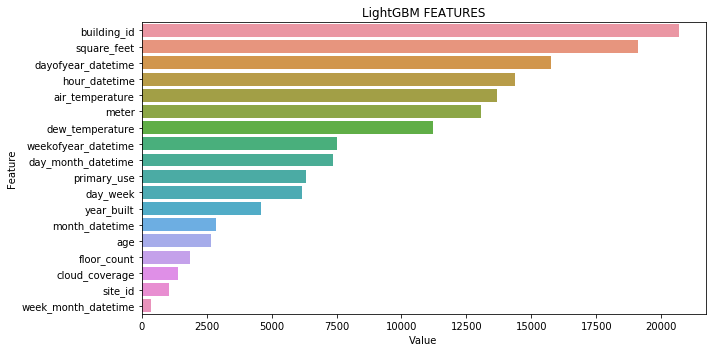

Wall time: 195 ms


In [85]:
%%time
import matplotlib.pyplot as plt
import seaborn as sns

feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), gbm.feature_name()),reverse = True), columns=['Value','Feature'])
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM FEATURES')
plt.tight_layout()
plt.show()

In [86]:
%%time
i = 0
res = []
step_size = 50000
for j in tqdm(range(int(np.ceil(test_df.shape[0] / 50000)))):
    res.append(np.expm1(sum([model.predict(test_df.iloc[i:i + step_size]) for model in models]) / folds))
    i += step_size

100%|████████████████████████████████████████████████████████████████████████████████| 834/834 [48:34<00:00,  3.79s/it]


Wall time: 48min 34s


In [87]:
%%time
from datetime import datetime

res = np.concatenate(res)
sample_submission["meter_reading"] = res
sample_submission.loc[sample_submission['meter_reading'] < 0, 'meter_reading'] = 0
sample_submission.to_csv('sub_' + str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.csv', index=False)
sample_submission.head(10)

Wall time: 1min 53s


,row_id,meter_reading
0,0,1.467596
1,1,2.708240
2,2,0.675419
3,3,0.503249
4,4,1.098647
5,5,0.926444
6,6,0.000000
7,7,0.681805
8,8,152.908248
9,9,0.000000


,row_id,meter_reading
0,0,0.826118
1,1,0.764807
2,2,2.420179
3,3,0.000000
4,4,7.110291
5,5,0.826118
6,6,0.000000
7,7,8.606447
8,8,71.712868
9,9,0.015876


General findings
Published Articles on Energy Consumtion Prediction

https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113080#latest-665324

Geo location:

https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115040#latest-667889 https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115698#latest-667385 https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115698#latest-667385

Outliers:

https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113254

Holidays:

https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113286

Metric:

https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113064#latest-663076

